## Run Gene Set Enrichment Analysis (GSEA) Enrichr using gseapy for the partitioned Aging components using the feature loading of the latent factors grouped into each parition

In [1]:
!date

Fri Jun 21 11:17:13 EDT 2024


#### import libraries

In [2]:
from pandas import read_csv, concat, DataFrame, pivot
from gseapy.enrichr import Enrichr
from json import load as json_load
from igraph import Graph
from time import sleep
import statsmodels.stats.multitest as smm
from numpy import log10
from math import ceil
from re import match
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# parameters
project = 'aging_phase2'
latent_type = 'all'

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase2'
results_dir = f'{wrk_dir}/results'
figures_dir = f'{wrk_dir}/figures'

# in files
latent_part_file = f'{figures_dir}/{project}.latents.{latent_type}.partitioned_factors.json'
graphml_file = f'{figures_dir}/{project}.latents.{latent_type}.graphml'

# out files
figure_file = f'{figures_dir}/{project}.latents.{latent_type}.gsea_enrichr.png'
results_file = f'{figures_dir}/{project}.latents.{latent_type}.gsea_enrichr.csv'

# constants and variables
DEBUG = True
categories = ['broad', 'specific']
# won't use ATAC here only genes
# modalities = ['GEX', 'ATAC']
MODALITY = 'GEX'
REGRESSION_TYPE = 'glm_tweedie'
marker_sets = ['MSigDB_Hallmark_2020',
               'GO_Biological_Process_2023', 
               'GO_Cellular_Component_2023',
               'GO_Molecular_Function_2023', 
               'KEGG_2019_Human']
PAUSE_AMT = 2
dpi_value = 50

### load age associated features

In [4]:
results = []
for category in categories:
    print(category)
    in_file = (f'{results_dir}/{project}.{MODALITY}.{category}.'
               f'{REGRESSION_TYPE}_fdr_filtered.age.csv')
    this_df = read_csv(in_file)
    this_df['category'] = category
    results.append(this_df)
age_glm_df = concat(results)
print(f'shape of all age associated features {age_glm_df.shape}')
if DEBUG:
    display(age_glm_df.sample(4))
    display(age_glm_df.category.value_counts())

broad
specific
shape of all age associated features (6272, 10)


,feature,intercept,coef,stderr,z,p-value,tissue,type,fdr_bh,category
1157,SLC6A1,-1.559101,-0.028258,0.008256,-3.422949,0.000619,Micro,curated_type,0.036897,broad
1559,LINC00390,-3.004105,0.016713,0.004069,4.107126,0.000040,InN-12,cluster_name,0.013782,specific
2856,AC117944.1,-4.228003,-0.017560,0.004953,-3.545599,0.000392,InN-18,cluster_name,0.041035,specific
916,NMRAL1,-2.320572,0.019005,0.005330,3.565526,0.000363,Micro-3,cluster_name,0.039516,specific


specific    3777
broad       2495
Name: category, dtype: int64

### load the partitioned age associated latent factors graph

In [5]:
latent_graph = Graph.Read_GraphML(graphml_file)
if DEBUG:
    print(latent_graph.vcount())
    print(latent_graph.ecount())
feature_nodes = latent_graph.vs.select(type='feature')
print(f'length non-latent feature nodes in the latent graph is {len(feature_nodes)}')

38177
239968
length non-latent feature nodes in the latent graph is 37981


### load the partitioned age associated latent factors

In [6]:
with open(latent_part_file, 'r') as in_file:
    partitioned_factors = json_load(in_file)
print(f'length of partitioned_factors is {len(partitioned_factors)}')

length of partitioned_factors is 9


#### extract the partition groups and cell types

In [7]:
age_latents = {}
for part_index, latents in partitioned_factors.items():
    latent_name = f'Aging-{part_index}'
    pairs = [element.split(':')[0] for element in latents]
    age_latents[latent_name] = list(set(pairs))
print(f'age_latents length is {len(age_latents)}')
if DEBUG:
    display(age_latents)  

age_latents length is 9


{'Aging-5': ['OD-0', 'OD-21', 'OD'],
 'Aging-6': ['ExN-19',
  'InN',
  'InN-18',
  'ExN-8',
  'InN-13',
  'ExN-15',
  'InN-5',
  'InN-12',
  'InN-10',
  'InN-23'],
 'Aging-3': ['ExN-9', 'ExN-14'],
 'Aging-2': ['OPC-4', 'OPC'],
 'Aging-0': ['Micro-3', 'Micro'],
 'Aging-4': ['ExN-7', 'ExN-2', 'ExN-6', 'ExN'],
 'Aging-1': ['Astro', 'Astro-1', 'OD-21'],
 'Aging-7': ['PeriVasc-20', 'VLMC', 'VLMC-22', 'PeriVasc'],
 'Aging-8': ['ExN-25']}

### resolve the cell-types to their age associate features

In [8]:
latent_features = {}
for latent, cell_types in age_latents.items():
    print(latent, cell_types)
    age_features = {}
    for cell_type in cell_types:
        these_results = age_glm_df.loc[age_glm_df.tissue == cell_type]
        if len(age_features) == 0:
            age_features = set(these_results.feature)
        else:
            age_features = age_features | set(these_results.feature)
    latent_features[latent] = age_features
    print(f'{latent} has {len(age_features)} features')

Aging-5 ['OD-0', 'OD-21', 'OD']
Aging-5 has 227 features
Aging-6 ['ExN-19', 'InN', 'InN-18', 'ExN-8', 'InN-13', 'ExN-15', 'InN-5', 'InN-12', 'InN-10', 'InN-23']
Aging-6 has 1334 features
Aging-3 ['ExN-9', 'ExN-14']
Aging-3 has 271 features
Aging-2 ['OPC-4', 'OPC']
Aging-2 has 191 features
Aging-0 ['Micro-3', 'Micro']
Aging-0 has 717 features
Aging-4 ['ExN-7', 'ExN-2', 'ExN-6', 'ExN']
Aging-4 has 1069 features
Aging-1 ['Astro', 'Astro-1', 'OD-21']
Aging-1 has 564 features
Aging-7 ['PeriVasc-20', 'VLMC', 'VLMC-22', 'PeriVasc']
Aging-7 has 95 features
Aging-8 ['ExN-25']
Aging-8 has 21 features


### alternatively group features from the partitioned graph; ie these would be based on latent age factor loadings

In [9]:
# regex pattern for match ATAC peaks naming format
pattern = r'^chr.*:.*-.*$'
latent_features = {}
for part_index in partitioned_factors.keys():
    latent_name = f'Aging-{part_index}'
    member_nodes = feature_nodes.select(membership=float(part_index))
    print(latent_name, len(member_nodes))
    age_features = []
    for node in member_nodes:
        # only add genes not ATAC peaks, peaks are in GSEA libraries
        if not match(pattern, node['name']):
            age_features.append(node['name'])
    latent_features[latent_name] = list(set(age_features))
    print(f'{latent_name} has {len(age_features)} feature loadings')

Aging-5 1851
Aging-5 has 177 feature loadings
Aging-6 1703
Aging-6 has 1167 feature loadings
Aging-3 4067
Aging-3 has 116 feature loadings
Aging-2 4476
Aging-2 has 117 feature loadings
Aging-0 12929
Aging-0 has 609 feature loadings
Aging-4 3962
Aging-4 has 786 feature loadings
Aging-1 8540
Aging-1 has 322 feature loadings
Aging-7 435
Aging-7 has 93 feature loadings
Aging-8 18
Aging-8 has 18 feature loadings


### run the GSEA Enrichr

#### if debugging see available GSEA libraries

In [10]:
if DEBUG:
    import gseapy
    gene_set_names = gseapy.get_library_name(organism='Human')
    print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Per

#### utility functions for accessing and scoring GSEA Enrichr

In [11]:
def find_enrichment(name: str, genes: list, sets,
                    verbose: bool=False) -> DataFrame:
    enr_res = gseapy.enrichr(gene_list=genes,
                             organism='Human',
                             gene_sets=sets,
                             cutoff=0.5)
    enr_res.results['factor'] = name    
    if verbose:
        print(f'full {sets} results shape{enr_res.results.shape}')        
        sig = enr_res.results.loc[enr_res.results['Adjusted P-value'] <= 0.05]
        print(f'significant {sets} results shape{sig.shape}')
        display(sig)
    return enr_res.results

In [12]:
results = []
for latent, gene_list in latent_features.items():
    print(f'\n########### {latent} ###########')
    for gene_set in marker_sets:
        print(f'\n+++++++++++ {gene_set} +++++++++++')
        results.append(find_enrichment(latent, list(gene_list), gene_set, verbose=False))
        sleep(PAUSE_AMT)


########### Aging-5 ###########

+++++++++++ MSigDB_Hallmark_2020 +++++++++++

+++++++++++ GO_Biological_Process_2023 +++++++++++

+++++++++++ GO_Cellular_Component_2023 +++++++++++

+++++++++++ GO_Molecular_Function_2023 +++++++++++

+++++++++++ KEGG_2019_Human +++++++++++

########### Aging-6 ###########

+++++++++++ MSigDB_Hallmark_2020 +++++++++++

+++++++++++ GO_Biological_Process_2023 +++++++++++

+++++++++++ GO_Cellular_Component_2023 +++++++++++

+++++++++++ GO_Molecular_Function_2023 +++++++++++

+++++++++++ KEGG_2019_Human +++++++++++

########### Aging-3 ###########

+++++++++++ MSigDB_Hallmark_2020 +++++++++++

+++++++++++ GO_Biological_Process_2023 +++++++++++

+++++++++++ GO_Cellular_Component_2023 +++++++++++

+++++++++++ GO_Molecular_Function_2023 +++++++++++

+++++++++++ KEGG_2019_Human +++++++++++

########### Aging-2 ###########

+++++++++++ MSigDB_Hallmark_2020 +++++++++++

+++++++++++ GO_Biological_Process_2023 +++++++++++

+++++++++++ GO_Cellular_Component_2023 +

#### convert full enrichment results into combined data frame

In [18]:
results_df = concat(results)
print(f'full results shape {results_df.shape}')
if DEBUG:
    display(results_df.sample(5))
    display(results_df.Gene_set.value_counts())

full results shape (17113, 11)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,factor
1053,GO_Biological_Process_2023,Regulation Of Glycolytic Process (GO:0006110),1/40,0.799174,0.999993,0,0,0.626327,0.140408,P2RX7,Aging-4
67,GO_Biological_Process_2023,Regulation Of DNA Repair (GO:0006282),6/129,0.018184,0.474794,0,0,3.018679,12.096486,BABAM2;SMARCD3;UBE2N;BRD7;TAF5L;PML,Aging-1
387,GO_Biological_Process_2023,Anterior/Posterior Pattern Specification (GO:0...,1/59,0.240724,0.384292,0,0,3.719828,5.297425,SKI,Aging-7
255,GO_Molecular_Function_2023,Heme Binding (GO:0020037),2/87,0.861261,0.999994,0,0,0.574100,0.085746,CYB5A;CYB561D2,Aging-4
9,MSigDB_Hallmark_2020,Hedgehog Signaling,1/36,0.274068,0.819659,0,0,3.212338,4.157981,MYH9,Aging-5


GO_Biological_Process_2023    11863
GO_Molecular_Function_2023     2326
KEGG_2019_Human                1341
GO_Cellular_Component_2023     1282
MSigDB_Hallmark_2020            301
Name: Gene_set, dtype: int64

### clean-up the GO term entity

In [19]:
results_df['Gene_set'] = results_df.Gene_set.str.replace('GO_','')
results_df['Gene_set'] = results_df.Gene_set.str.replace('_2020','')
results_df['Gene_set'] = results_df.Gene_set.str.replace('_2023','')
results_df['Gene_set'] = results_df.Gene_set.str.replace('_2019_Human','')
results_df['Term'] = results_df.Gene_set + ': ' + results_df.Term
print(f'shape of GSEA post Term naming cleanup {results_df.shape}')
if DEBUG:
    display(results_df.sample(5))

shape of GSEA post Term naming cleanup (17113, 11)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,factor
1565,Biological_Process,Biological_Process: Negative Regulation Of Neu...,1/54,0.584239,0.667755,0,0,1.153530,0.619958,EFNA1,Aging-1
157,Cellular_Component,Cellular_Component: trans-Golgi Network (GO:00...,3/241,0.996367,0.999993,0,0,0.305483,0.001112,CLBA1;TRAPPC9;SLC24A5,Aging-4
38,Cellular_Component,Cellular_Component: Cornified Envelope (GO:000...,2/41,0.482844,0.999993,0,0,1.254252,0.913171,JUP;HRNR,Aging-4
18,Biological_Process,Biological_Process: Regulation Of Type B Pancr...,1/5,0.023037,0.308136,0,0,54.084239,203.933174,NUPR1,Aging-7
619,Biological_Process,Biological_Process: Activation Of Adenylate Cy...,1/20,0.551681,0.999993,0,0,1.286959,0.765466,GIPR,Aging-4


#### how many are statistically significant

In [20]:
alpha = 0.05
sig_results = results_df.loc[results_df['Adjusted P-value'] <= alpha]
print(f'{sig_results.shape[0]} terms were detected')
if sig_results.shape[0] < 20:
    display(sig_results.sort_values('Odds Ratio', ascending=False))
else:
    display(sig_results.sort_values('Odds Ratio', ascending=False).head(20))

9 terms were detected


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,factor
0,Biological_Process,Biological_Process: Purine Nucleotide Metaboli...,2/34,0.000422,0.029764,0,0,77.929688,605.569275,GUK1;PPAT,Aging-8
1,Biological_Process,"Biological_Process: RNA Splicing, Via Transest...",3/180,0.000530,0.029764,0,0,22.378531,168.810727,PPIL1;HNRNPH1;SRSF12,Aging-8
2,Biological_Process,"Biological_Process: mRNA Splicing, Via Spliceo...",3/211,0.000840,0.029764,0,0,19.013462,134.647566,PPIL1;HNRNPH1;SRSF12,Aging-8
3,Biological_Process,Biological_Process: mRNA Processing (GO:0006397),3/214,0.000875,0.029764,0,0,18.740284,131.947167,PPIL1;HNRNPH1;SRSF12,Aging-8
0,Biological_Process,Biological_Process: Vascular Transport (GO:001...,12/83,0.000008,0.013109,0,0,5.469602,64.415183,ABCC4;SLC7A5;SLC13A3;SLC24A3;SLC16A1;SLC1A3;AT...,Aging-0
1,Biological_Process,Biological_Process: Transport Across Blood-Bra...,12/85,0.000010,0.013109,0,0,5.319199,61.308643,ABCC4;SLC7A5;SLC13A3;SLC24A3;SLC16A1;SLC1A3;AT...,Aging-0
0,KEGG,KEGG: Th1 and Th2 cell differentiation,11/92,0.000110,0.027979,0,0,4.385193,39.982349,NOTCH2;MAPK10;MAPK9;PPP3CB;CD4;IL4R;MAML1;JAK3...,Aging-0
0,MSigDB_Hallmark,MSigDB_Hallmark: TNF-alpha Signaling via NF-kB,17/200,0.000140,0.006857,0,0,3.014104,26.748020,PTGER4;CD83;PFKFB3;GADD45B;PLAUR;LITAF;SAT1;ET...,Aging-0
1,MSigDB_Hallmark,MSigDB_Hallmark: Complement,16/200,0.000431,0.010553,0,0,2.816482,21.827845,LYN;CPM;C1S;PRKCD;PLAUR;CBLB;RNF4;CP;RBSN;PLSC...,Aging-0


### save the GSEA Enrichments detected

In [21]:
sig_results.to_csv(results_file)

### reshape the dataframe from long to wide

In [22]:

# # compute -log10 of p-value
# results_df['log10_pvalue'] = -log10(results_df['P-value'])
# w_df = pivot(results_df.loc[results_df.Term.isin(sig_results.Term)], 
#                   index=['Term'], 
#                   columns=['factor'], values='log10_pvalue')
w_df = pivot(results_df.loc[results_df.Term.isin(sig_results.Term)], 
                  index=['Term'], 
                  columns=['factor'], values='Odds Ratio')
# set precision
w_df = w_df.round(2)
# drop rows that are all null
w_df.dropna(how='all', inplace=True)
print(f'shape of wide reformated results {w_df.shape}')
if DEBUG:
    display(w_df)

shape of wide reformated results (9, 9)


factor,Aging-0,Aging-1,Aging-2,Aging-3,Aging-4,Aging-5,Aging-6,Aging-7,Aging-8
Term,,,,,,,,,
Biological_Process: Purine Nucleotide Metabolic Process (GO:0006163),1.99,NaN,NaN,5.23,NaN,7.07,NaN,NaN,77.93
"Biological_Process: RNA Splicing, Via Transesterification Reactions With Bulged Adenosine As Nucleophile (GO:0000377)",0.54,NaN,NaN,NaN,0.70,2.58,0.46,1.20,22.38
Biological_Process: Transport Across Blood-Brain Barrier (GO:0150104),5.32,1.48,NaN,NaN,0.59,NaN,1.23,NaN,NaN
Biological_Process: Vascular Transport (GO:0010232),5.47,1.51,NaN,NaN,0.60,NaN,1.03,NaN,NaN
Biological_Process: mRNA Processing (GO:0006397),0.60,0.28,NaN,0.80,0.58,2.73,0.62,1.01,18.74
"Biological_Process: mRNA Splicing, Via Spliceosome (GO:0000398)",0.46,0.29,0.81,0.81,0.71,2.77,0.55,1.02,19.01
KEGG: Th1 and Th2 cell differentiation,4.39,0.67,NaN,1.89,0.27,NaN,0.73,NaN,NaN
MSigDB_Hallmark: Complement,2.82,1.58,NaN,0.86,1.02,0.56,0.85,3.34,NaN
MSigDB_Hallmark: TNF-alpha Signaling via NF-kB,3.01,2.93,NaN,NaN,0.50,1.72,0.76,NaN,NaN


### visualize the reformated data as a heatmap

9


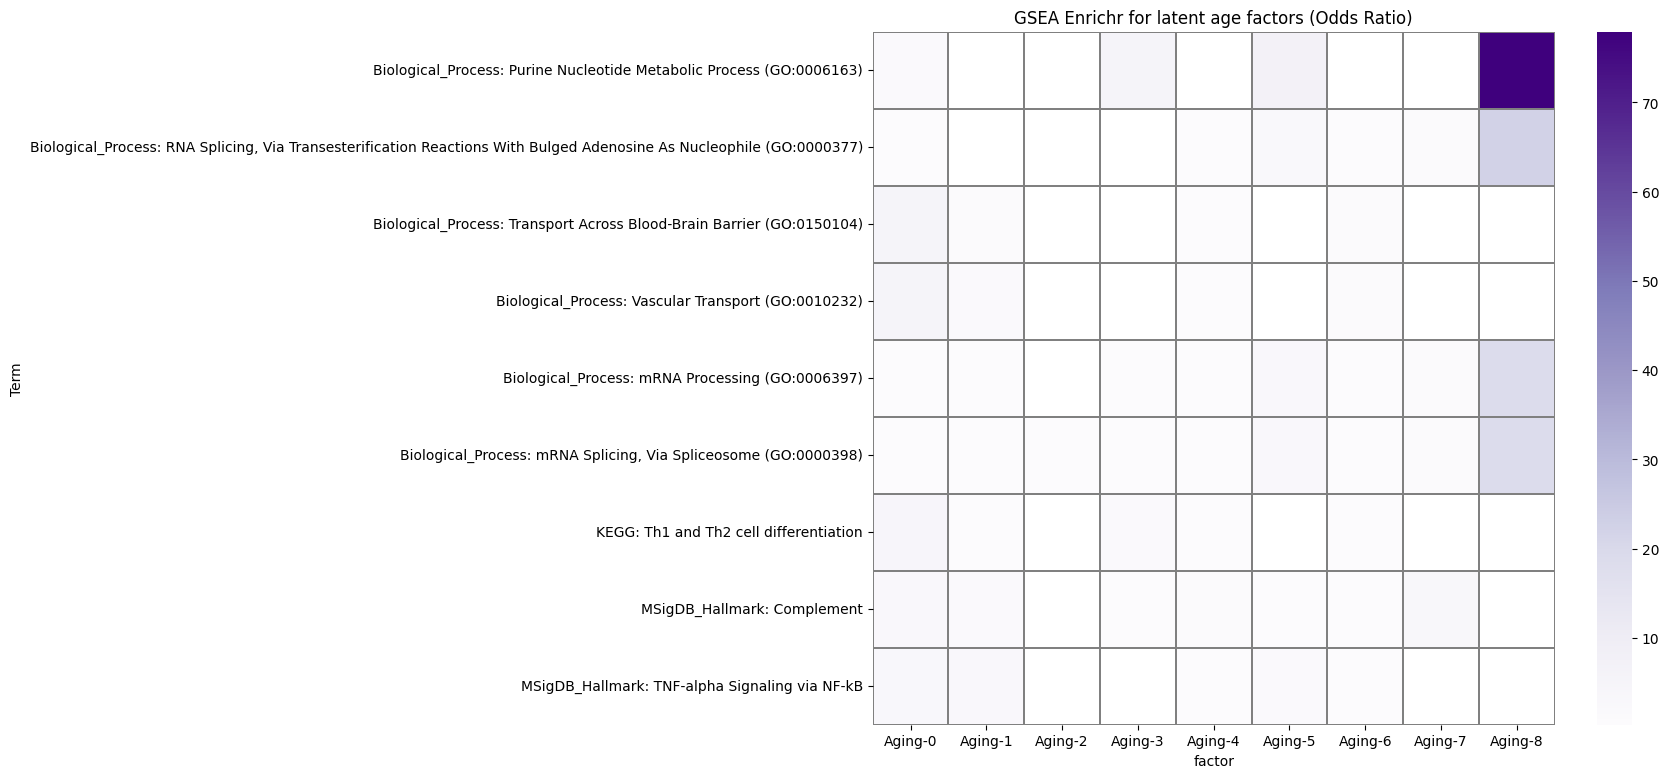

In [23]:
from seaborn import heatmap

if w_df.shape[0] > 9:
    height = 9+ceil(w_df.shape[0]/5)
else:
    height = 9
print(height)        
with rc_context({'figure.figsize': (11, height), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-v0_8-bright')    
    heatmap(w_df, linecolor='grey', linewidths=0.05, cmap='Purples')    
    plt.title(f'GSEA Enrichr for latent age factors (Odds Ratio)')
    plt.savefig(figure_file, dpi=dpi_value, bbox_inches='tight', 
                transparent=True, pad_inches=1)
    plt.show()

### visualize as clustered heatmap

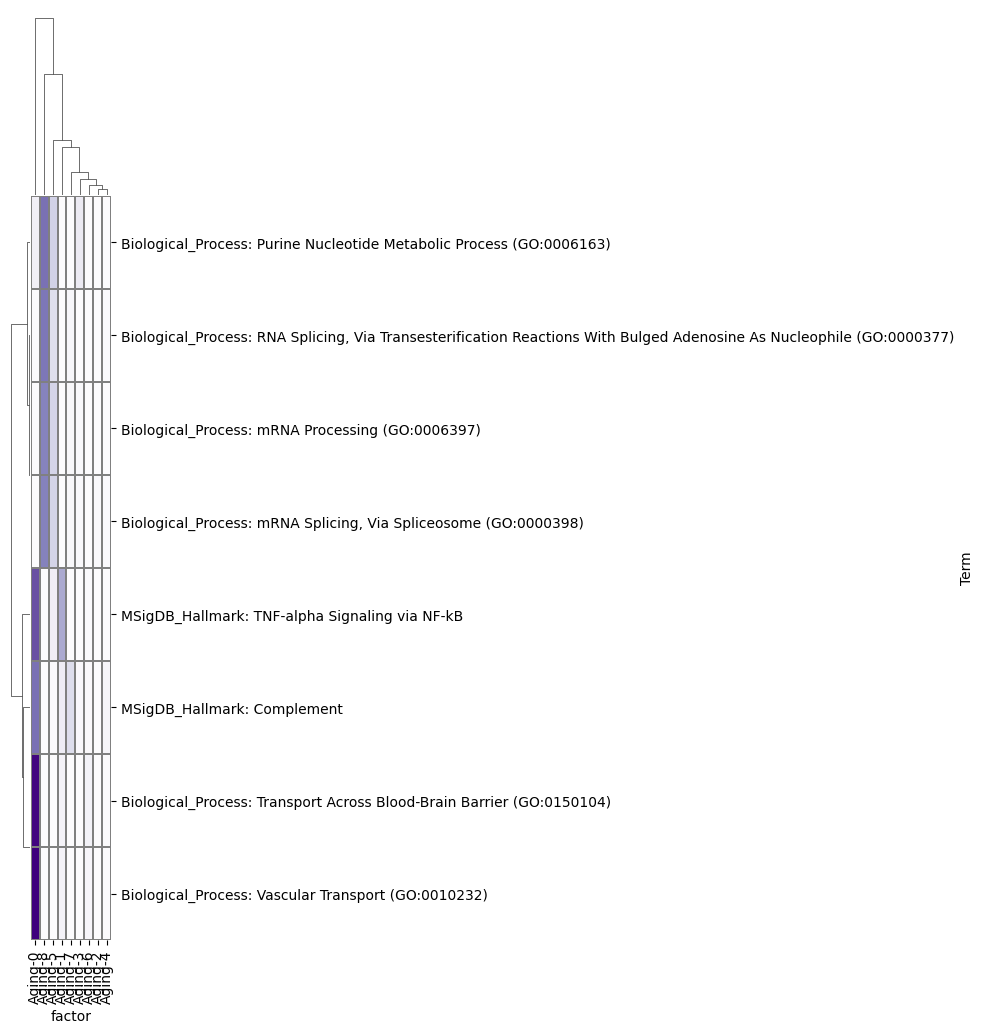

In [80]:
from seaborn import clustermap

# fill the missing
w_df = w_df.fillna(0)

with rc_context({'figure.figsize': (11, height), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-v0_8-bright')    
    # clustermap(w_df, cmap='Purples', cbar_pos=(0.75, 0.9, 0.05, 0.18))
    clustermap(w_df, cmap='Purples', cbar_pos=None, linecolor='grey', linewidths=0.05)        
    # plt.title('GSEA Enrichr')
    plt.xticks(rotation = 90)
    # plt.savefig(figure_file, dpi=dpi_value, bbox_inches='tight', 
    #             transparent=True, pad_inches=1)
    plt.show()

In [81]:
!date

Fri Jun 21 09:51:40 EDT 2024
